In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [80]:
# F1 для training и validation
train_f1_metric = MulticlassF1Score(num_classes=10, average='macro').to(device)
val_f1_metric = MulticlassF1Score(num_classes=10, average='macro').to(device)

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

# Трансформации для данных (нормализация)
transform = transforms.Compose([
    transforms.ToTensor()
])

In [81]:
# Загрузка датасета MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [82]:
# Определение модели сверточной нейронной сети
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)  # 1 канал вход, 32 выхода, ядро 5x5
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling 2x2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 1000)  # размер после свертки и пулинга
        self.fc2 = nn.Linear(1000, 10)  # 10 классов

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # conv1 + ReLU + maxpool
        x = self.pool(torch.relu(self.conv2(x)))  # conv2 + ReLU + maxpool
        x = x.view(-1, 64 * 4 * 4)  # разворот в плоский вектор
        x = torch.relu(self.fc1(x))  # полносвязный слой + ReLU
        x = self.fc2(x)  # выходной слой
        return x

In [83]:
# Инициализация сети, функции потерь и оптимизатора
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
def train(model, device, train_loader, optimizer, criterion, f1_metric):
    model.train()
    running_loss = 0.0
    f1_metric.reset()
    train_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for data, target in train_tqdm:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1)
        f1_metric.update(pred, target)
        train_tqdm.set_postfix(loss=loss.item())
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    f1_score = f1_metric.compute()
    train_f1_scores.append(f1_score.item())
    print(f'Train loss: {avg_loss:.4f}, Train F1: {f1_score:.4f}')

In [85]:
def validate(model, device, val_loader, criterion, f1_metric):
    model.eval()
    val_loss = 0.0
    correct = 0
    f1_metric.reset()
    val_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for data, target in val_tqdm:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            f1_metric.update(pred, target)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    f1_score = f1_metric.compute()
    val_f1_scores.append(f1_score.item())
    print(f'Validation loss: {avg_val_loss:.4f}, Validation F1: {f1_score:.4f}, Accuracy: {correct / len(val_loader.dataset):.4f}')

In [86]:
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.plot(epochs, train_f1_scores, 'c-', label='Train F1')
    plt.plot(epochs, val_f1_scores, 'g-', label='Validation F1')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Metrics')
    plt.show()

In [87]:
# Выбор устройства (GPU если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [88]:
# Пример цикла обучения
for epoch in range(1, 6):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion, train_f1_metric)
    validate(model, device, test_loader, criterion, val_f1_metric)


Epoch 1


Train loss: 0.1295, Train F1: 0.9599


Validation loss: 0.0452, Validation F1: 0.9854, Accuracy: 0.9854
Epoch 2


Train loss: 0.0403, Train F1: 0.9874


Validation loss: 0.0351, Validation F1: 0.9883, Accuracy: 0.9884
Epoch 3


Train loss: 0.0267, Train F1: 0.9913


Validation loss: 0.0286, Validation F1: 0.9905, Accuracy: 0.9906
Epoch 4


Train loss: 0.0191, Train F1: 0.9938


Validation loss: 0.0373, Validation F1: 0.9885, Accuracy: 0.9885
Epoch 5


Train loss: 0.0149, Train F1: 0.9953


Validation loss: 0.0336, Validation F1: 0.9904, Accuracy: 0.9904


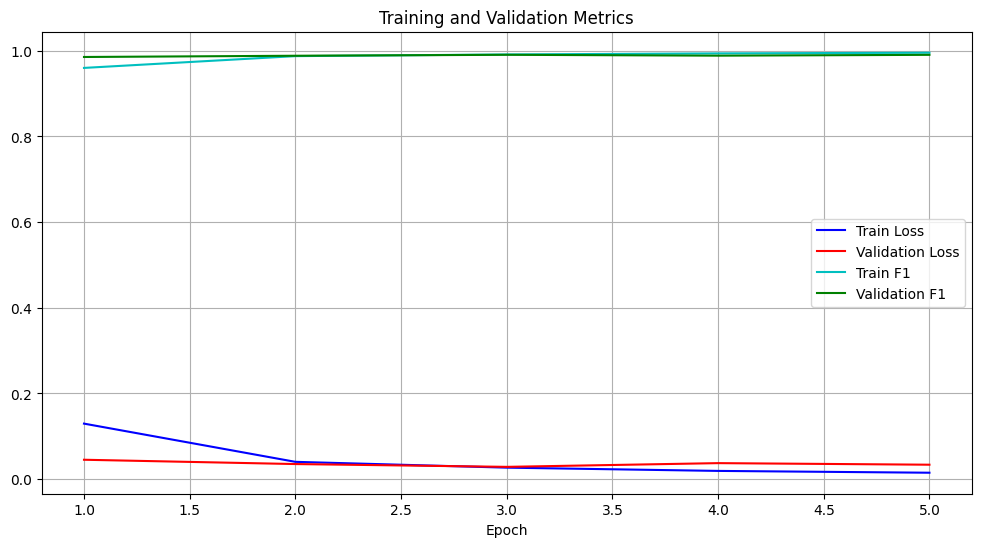

In [89]:
# График с метриками
plot_metrics()